<a href="https://colab.research.google.com/github/prteek/data-science/blob/master/GradientDescent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gradient Descent
*Those who brag of their descent, brag on what they owe to others. -Seneca*

In [0]:
# This cell is not required to be executed (i.e. ignore any error) if Notebook is run locally or in Binder
# Authorise and mount google drive to access code and data files

project_folder = '/content/drive/My Drive/git_repos/data-science/'

import os

if os.path.isdir('/content'):
    from google.colab import drive
    drive.mount('/content/drive')

    if not(os.path.isdir(project_folder)):
      os.makedirs(project_folder)
      print("new project folder created")

    os.chdir(project_folder)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%%capture
# To supress the output when calling another file
%run ./HypothesisAndInference.ipynb

### Estimating the gradient
Here's an example of estimatimg derivative of a single valued function.

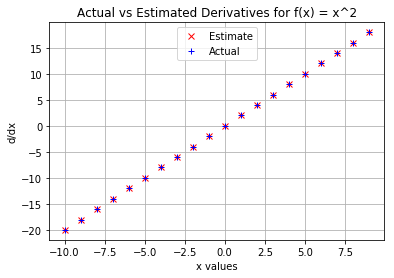

In [0]:
def difference_quotient(f,x,h=0.00001):
    return (f(x+h) - f(x))/h

def square(x):
    return x**2

def derivative_square(x):
    return 2*x

xs = range(-10,10)
derivative_estimate = [difference_quotient(square, x, 0.00001) for x in xs]
derivative_actual   = [derivative_square(x) for x in xs]

plt.plot(xs, derivative_estimate,"rx",label="Estimate")
plt.plot(xs, derivative_estimate,"b+",label="Actual")
plt.title("Actual vs Estimated Derivatives for f(x) = x^2")
plt.xlabel('x values')
plt.ylabel('d/dx')
plt.legend(loc="upper center")
plt.grid()
plt.show()

In [0]:
def partial_difference_quotient(f, v, i, h=0.00001):
    """Compute the ith partial difference quotient of f at v"""
    w = [v_j + (h if i==j else 0)  # add h to just the ith element of v
        for j, v_j in enumerate(v)]
    return (f(w) - f(v))/h

def estimate_gradient(f, v, h=0.00001):
    """This is computationally expensive. If v has length n then estimate_gradient
    has to evaluate f on 2n (f(w) and f(v)) different inputs."""
    return [partial_difference_quotient(f, v, i, h) for i, _ in enumerate(v)]

### Using the Gradient
We'll just pick a random starting point and then take tiny steps in the opposite direction of gradient until we reach a point where the gradient is very small

In [0]:
def sum_of_squares_min(v): # Function to be minimised
    return sum([v_i**2 for v_i in v])

def step(v, direction, step_size):
    """move step_size in the direction from v"""
    return [v_i + step_size*direction_i for v_i, direction_i in zip(v,direction)]

def sum_of_squares_gradient(v): # actual gradient function
    return [2*v_i for v_i in v]

# Pick a random starting point
v = [random.randint(-10,10) for i in range(3)]

tolerance = 0.0000001

while True:
    gradient = sum_of_squares_gradient(v) # compute the gradient at v
    next_v   = step(v, gradient, -0.01)   # take a negative gradient step
    if distance(next_v,v) < tolerance:    # stop if we're converging
        break
    v = next_v                            # continue if we're not

print("Minima with actual gradient:", v)

while True:
    gradient = estimate_gradient(sum_of_squares, v) # compute the gradient at v
    next_v   = step(v, gradient, -0.01)   # take a negative gradient step
    if distance(next_v,v) < tolerance:    # stop if we're converging
        break
    v = next_v                            # continue if we're not
    
print("Minima with estimated gradient", v)

Minima with actual gradient: [4.5336994434236267e-07, -2.720219666054177e-06, -4.080329499081268e-06]
Minima with estimated gradient [-4.532650128367352e-07, -3.0992382484243446e-06, -4.233226777961894e-06]


### Choosing the right Step Size
Following options can be followed in selection of right step size:
* Using a fixed step size
* Gradually, shrinking the step size over time
* At each step, choosing the step size that minimizes the value of the objective function (Computationally expensive)  

The last option can be approximated by trying different step sizes and choosing the one that results in the smallest value of the objective function <br /> step_sizes = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]. <br />
It is possible that some of the step sizes will result in invalid inputs for the function that is being minimized so a *safe apply* function is required

In [0]:
def safe(f):
    """return a new function that is the same as f, 
    except that it outputs infinity whenever f produces an error"""
    def safe_f(*args, **kwargs):
        try:
            return f(*args,**kwargs)
        except:
            return float('inf')
    return safe_f

### Putting it all together
In general we'll have some target_fn that we want to minimize and we also have its gradient_fn which is gradient w.r.t. *theta* (and not function input data). 
For example target_fn can be the sum of error in a model over the entire dataset for a given set of *theta* and we want to find the *theta* for which errors are minimum. 

In [0]:
# It is implicit here that target_fn and gradient_fn operate over entire data set of x and y 
# and minimisation is performed w.r.t. theta

def minimize_batch(target_fn, gradient_fn, theta_0, tolerance=0.0000001):
    """use gradient descent to find theta that minimizes target function"""
    step_sizes = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
    target_fn  = safe(target_fn)   # safe version of target function
    value      = target_fn(theta_0)# value we are minimising
    next_value = value+1           # to enter while loop
    next_theta = theta_0           # set theta to initial value
    while abs(value - next_value)>tolerance:
        theta                = next_theta
        value                = next_value
        gradient             = gradient_fn(theta)
        next_thetas          = [step(theta, gradient, -step_size) for step_size in step_sizes]
        # chose the theta that minimizes target_fn
        target_fn_for_thetas = [target_fn(theta_i) for theta_i in next_thetas]
        min_target_fn_index  = [i for i,val in enumerate(target_fn_for_thetas) 
                                if val==min(target_fn_for_thetas)]
        next_theta           = next_thetas[min_target_fn_index[0]]
        next_value           = target_fn(next_theta)

    return theta

# sometimes we'd like to maximize a function which we can do by minimising its negative

def negate(f):
    """return a function that for any input x returns -f(x)"""
    return lambda *args, **kwargs: -f(*args,**kwargs)

def negate_all(f):
    """the same when f returns a list of numbers"""
    return lambda *args, **kwargs: [-y for y in f(*args,**kwargs)]

def maximize_batch(target_fn, gradient_fn, theta_0, tolerance=0.0000001):
    return minimize_batch(negate(target_fn), negate_all(gradient_fn), theta_0, tolerance)

### Stochastic Gradient Descent
Batch approach requires in each gradient step we make a prediction and compute the gradient for the whole data set, which makes each step take long time.<br/>

Detailed explanation: https://www.youtube.com/watch?v=HLf4QNAwsd0

Usually, the error functions are *additive* which means that the predictive error on the whole data set is simply the sum of the predictive errors for each data point. <br/> 

When this is the case, we can instead apply a technique called *stochastic gradient descent*, which computes the gradient (and takes a step) for only one point at a time. It cycles over our data repeatedly until it reaches a stopping point.<br/>

During each cycle, we'll want to iterate through our data in random order:

In [0]:
def in_random_order(data):
    """generator that returns the elements of data in random order"""
    indexes = [i for i,_ in enumerate(data)]
    random.shuffle(indexes)
    for i in indexes:
        yield data[i]

# This approach leaves the possibility that we might circle around near minimum forever, 
# so whenever we stop getting improvements we'll decrease step size and eventually stop:

# Here only target_fn operates over entire data set but gradient_fn operates over single values of x and y
def minimize_stochastic(target_fn, gradient_fn, x,y, theta_0, alpha_0=0.01, iterations_threshold=10):
    data    = list(zip(x,y)) 
    theta   = theta_0    # initial guess
    alpha   = alpha_0    # initial step size
    min_theta, min_value = None, float("inf")  # the minimum value so far
    iterations_with_no_improvement = 0
    
    # if we ever go 10 iterations with no improvement, stop
    while iterations_with_no_improvement < iterations_threshold:
        value = sum(target_fn(x_i, y_i, theta) for x_i, y_i in data)
        
        if value < min_value:
            # if we've found a new minimum, remember it
            # and go back to the original step size
            min_theta, min_value = theta, value
            iterations_with_no_improvement = 0
            alpha = alpha_0
        else:
            # otherwise we're not improving, so try shrinking the step size
            iterations_with_no_improvement += 1
            alpha *= 0.9
            
        # and take a gradient step for each of the data points
        for x_i, y_i in in_random_order(data):
            gradient_i = gradient_fn(x_i, y_i, theta)
            theta      = vector_subtract(theta, scalar_multiply(alpha, gradient_i))
    
    return min_theta 


def maximize_stochastic(target_fn, gradient_fn, x,y, theta_0, alpha_0=0.01):
    return minimize_stochastic(negate(target_fn), negate_all(gradient_fn), x, y, theta_0, alpha_0)